# Problem 7: PPO (Proximal Policy Optimization)

## Cart Pole

### Observation Space
The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

### Action Space
The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

$\cdot$ 0: Push cart to the left

$\cdot$ 1: Push cart to the right

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Rewards
Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 500 for v1 and 200 for v0.

Reference: https://gymnasium.farama.org/environments/classic_control/cart_pole/

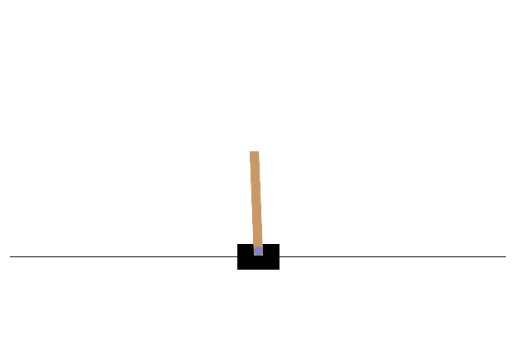

In [9]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=1)

img = env.render()

plt.imshow(img)
plt.axis("off")
plt.show()

In [1]:
# ==========================================================
# Fair DQN vs PPO Comparison (Discrete Action, Gymnasium)
# - Same env, seed, net size, and total env steps budget
# - One file, no nested functions
# ==========================================================
import random
from copy import deepcopy
from typing import List, Tuple

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [2]:
# ==========================================================
# 0) Utils
# ==========================================================
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def one_hot(idx: int, n: int) -> np.ndarray:
    v = np.zeros(n, dtype=np.float32)
    v[idx] = 1.0
    return v

def obs_to_np(obs, obs_space) -> np.ndarray:
    if isinstance(obs_space, gym.spaces.Discrete):
        return one_hot(int(obs), obs_space.n)
    elif isinstance(obs_space, gym.spaces.Box):
        return np.asarray(obs, dtype=np.float32)
    else:
        raise NotImplementedError(f"Unsupported obs space: {obs_space}")

def moving_average(arr, window=21):
    if window <= 1 or len(arr) == 0:
        return np.asarray(arr, dtype=float)
    arr = np.asarray(arr, dtype=float)
    cs = np.cumsum(np.insert(arr, 0, 0.0))
    core = (cs[window:] - cs[:-window]) / window
    left = window // 2
    right = len(arr) - len(core) - left
    return np.pad(core, (left, right), mode="edge")

# 공정한 평가: 탐욕 정책 N에피소드 평균 리턴
def evaluate_greedy(env_name: str, make_env_kwargs: dict, policy_fn, eval_episodes=10, seed=42):
    env = gym.make(env_name, **make_env_kwargs)
    obs_space, act_space = env.observation_space, env.action_space
    set_seed(seed)
    rets = []
    for _ in range(eval_episodes):
        obs, _ = env.reset(seed=seed)
        done = False
        ep_ret = 0.0
        while not done:
            x = obs_to_np(obs, obs_space)
            a = policy_fn(x)  # greedy action
            obs, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            ep_ret += r
        rets.append(ep_ret)
    env.close()
    return float(np.mean(rets))




In [3]:
# ==========================================================
# 1) DQN (Double DQN target, soft target update)
# ==========================================================
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: List[int], activation=nn.ReLU):
        super().__init__()
        dims = [input_dim] + list(hidden_dims)
        layers: List[nn.Module] = []
        for i in range(len(dims) - 1):
            layers += [nn.Linear(dims[i], dims[i+1]), activation()]
        layers += [nn.Linear(dims[-1], output_dim)]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.storage: List[Tuple[np.ndarray, int, float, np.ndarray, bool]] = []
        self.pos = 0
    def __len__(self): return len(self.storage)
    def push(self, s, a, r, ns, d):
        tr = (s, a, r, ns, d)
        if len(self.storage) < self.capacity:
            self.storage.append(tr)
        else:
            self.storage[self.pos] = tr
            self.pos = (self.pos + 1) % self.capacity
    def sample(self, batch_size: int):
        batch = random.sample(self.storage, batch_size)
        s, a, r, ns, d = zip(*batch)
        s  = torch.tensor(np.array(s),  dtype=torch.float32)
        a  = torch.tensor(a,           dtype=torch.long)
        r  = torch.tensor(r,           dtype=torch.float32)
        ns = torch.tensor(np.array(ns),dtype=torch.float32)
        d  = torch.tensor(d,           dtype=torch.float32)
        return s, a, r, ns, d



In [4]:
class DQNAgent:
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_dims: List[int],
        lr: float,
        gamma: float,
        tau: float,
        batch_size: int,
        target_update: int,
        epsilon_start: float,
        epsilon_final: float,
        epsilon_decay: float,
        memory_capacity: int,
        device: torch.device,
    ):
        self.q_network = QNetwork(input_dim, output_dim, hidden_dims).to(device)
        self.target_network = deepcopy(self.q_network).eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.target_update = target_update
        self.epsilon = epsilon_start
        self.epsilon_final = epsilon_final
        self.epsilon_decay = epsilon_decay
        self.replay = ReplayBuffer(memory_capacity)
        self.device = device
        self.steps = 0
        self.output_dim = output_dim

    def select_action(self, state_vec: np.ndarray) -> int:
        if random.random() < self.epsilon:
            return random.randint(0, self.output_dim - 1)
        with torch.no_grad():
            s = torch.from_numpy(state_vec).float().unsqueeze(0).to(self.device)
            q = self.q_network(s)
            return int(q.argmax(dim=1).item())

    def greedy_action_fn(self):
        def fn(state_vec_np: np.ndarray) -> int:
            with torch.no_grad():
                s = torch.from_numpy(state_vec_np).float().unsqueeze(0).to(self.device)
                return int(self.q_network(s).argmax(dim=1).item())
        return fn

    def store(self, s, a, r, ns, d):
        self.replay.push(s, a, r, ns, d)

    def train_step(self):
        if len(self.replay) < self.batch_size:
            return None
        s, a, r, ns, d = self.replay.sample(self.batch_size)
        s, a, r, ns, d = s.to(self.device), a.to(self.device), r.to(self.device), ns.to(self.device), d.to(self.device)

        q_sa = self.q_network(s).gather(1, a.view(-1, 1)).squeeze(1)

        with torch.no_grad():
            next_online = self.q_network(ns)
            next_a = next_online.argmax(dim=1, keepdim=True)
            next_target = self.target_network(ns)
            next_q = next_target.gather(1, next_a).squeeze(1)
            y = r + self.gamma * (1.0 - d) * next_q

        loss = nn.MSELoss()(q_sa, y)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 5.0)
        self.optimizer.step()

        self.epsilon = max(self.epsilon_final, self.epsilon * self.epsilon_decay)
        self.steps += 1
        if self.steps % self.target_update == 0:
            with torch.no_grad():
                for t, q in zip(self.target_network.parameters(), self.q_network.parameters()):
                    t.data.copy_(t.data * (1.0 - self.tau) + q.data * self.tau)
        return float(loss.item())

def train_dqn_fair(env_name: str, make_env_kwargs: dict, cfg: dict, total_steps: int, eval_every: int, eval_episodes: int, seed: int):
    env = gym.make(env_name, **make_env_kwargs)
    obs_space, act_space = env.observation_space, env.action_space
    set_seed(seed)
    obs, _ = env.reset(seed=seed)
    s = obs_to_np(obs, obs_space)
    input_dim = s.shape[0]
    output_dim = act_space.n

    agent = DQNAgent(
        input_dim=input_dim,
        output_dim=output_dim,
        hidden_dims=cfg["hidden_dims"],
        lr=cfg["dqn_lr"],
        gamma=cfg["gamma"],
        tau=cfg["tau"],
        batch_size=cfg["dqn_batch_size"],
        target_update=cfg["target_update"],
        epsilon_start=cfg["epsilon_start"],
        epsilon_final=cfg["epsilon_final"],
        epsilon_decay=cfg["epsilon_decay"],
        memory_capacity=cfg["memory_capacity"],
        device=cfg["device"],
    )

    train_returns = []
    eval_steps, eval_scores = [], []
    ep_ret = 0.0
    steps = 0
    while steps < total_steps:
        a = agent.select_action(s)
        next_obs, r, terminated, truncated, _ = env.step(a)
        d = bool(terminated or truncated)
        ns = obs_to_np(next_obs, obs_space)

        agent.store(s, a, r, ns, d)
        agent.train_step()

        ep_ret += r
        s = ns
        steps += 1

        if d:
            train_returns.append(ep_ret)
            ep_ret = 0.0
            obs, _ = env.reset()
            s = obs_to_np(obs, obs_space)

        if steps % eval_every == 0:
            mean_ret = evaluate_greedy(env_name, make_env_kwargs, agent.greedy_action_fn(), eval_episodes, seed)
            eval_steps.append(steps)
            eval_scores.append(mean_ret)
            print(f"[DQN] steps {steps:7d}/{total_steps} | eval_return {mean_ret:7.2f} | eps {agent.epsilon:6.3f}")

    env.close()
    return {"train_returns": train_returns, "eval_steps": eval_steps, "eval_scores": eval_scores, "agent": agent}




In [22]:
# ==========================================================
# 2) PPO (Categorical policy, GAE(γ,λ))
# ==========================================================
class ActorCritic(nn.Module):
    def __init__(self, input_dim: int, act_dim: int, hidden_dims: List[int], activation=nn.ReLU):
        super().__init__()
        dims = [input_dim] + list(hidden_dims)
        layers: List[nn.Module] = []
        for i in range(len(dims) - 1):
            layers += [nn.Linear(dims[i], dims[i+1]), activation()]
        self.body = nn.Sequential(*layers)
        self.pi = nn.Linear(dims[-1], act_dim)
        self.v  = nn.Linear(dims[-1], 1)
    def forward(self, x: torch.Tensor):
        z = self.body(x)
        return self.pi(z), self.v(z).squeeze(-1)

class RolloutBuf:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.reset()
    def reset(self):
        self.obs = []
        self.acts = []
        self.rews = []
        self.dones = []
        self.logps = []
        self.vals = []
    def add(self, obs, act, rew, done, logp, val):
        self.obs.append(obs); self.acts.append(act); self.rews.append(rew)
        self.dones.append(done); self.logps.append(logp); self.vals.append(val)

def compute_gae(rews, vals, dones, last_val, gamma=0.99, lam=0.95):
    T = len(rews)
    adv = np.zeros(T, dtype=np.float32)
    gae = 0.0
    for t in reversed(range(T)):
        next_nonterminal = 1.0 - float(dones[t])
        next_value = last_val if t == T - 1 else vals[t + 1]
        delta = rews[t] + gamma * next_value * next_nonterminal - vals[t]
        gae = delta + gamma * lam * next_nonterminal * gae
        adv[t] = gae
    ret = adv + np.array(vals, dtype=np.float32)
    return adv, ret

class PPOAgent:
    def __init__(self, input_dim: int, act_dim: int, hidden_dims: List[int], lr: float, clip_coef: float,
                 ent_coef: float, vf_coef: float, gamma: float, lam: float, update_epochs: int,
                 minibatch_size: int, device: torch.device, target_kl: float = 0.015):
        self.net = ActorCritic(input_dim, act_dim, hidden_dims).to(device)
        self.opt = optim.Adam(self.net.parameters(), lr=lr, eps=1e-5)
        self.clip_coef = clip_coef; self.ent_coef = ent_coef; self.vf_coef = vf_coef
        self.gamma = gamma; self.lam = lam
        self.update_epochs = update_epochs; self.minibatch_size = minibatch_size
        self.device = device; self.target_kl = target_kl

    @torch.no_grad()
    def select_action(self, s_np: np.ndarray) -> Tuple[int, float, float]:
        s = torch.from_numpy(s_np).float().unsqueeze(0).to(self.device)
        logits, v = self.net(s)
        dist = Categorical(logits=logits)
        a = dist.sample()
        logp = dist.log_prob(a)
        return int(a.item()), float(logp.item()), float(v.item())

    def greedy_action_fn(self):
        @torch.no_grad()
        def fn(state_vec_np: np.ndarray) -> int:
            s = torch.from_numpy(state_vec_np).float().unsqueeze(0).to(self.device)
            logits, _ = self.net(s)
            return int(torch.argmax(logits, dim=1).item())
        return fn

    def update(self, obs, acts, old_logps, advs, rets, old_vals):
        # Tensorize
        obs = torch.tensor(np.array(obs), dtype=torch.float32).to(self.device)
        acts = torch.tensor(np.array(acts), dtype=torch.long).to(self.device)
        old_logps = torch.tensor(np.array(old_logps), dtype=torch.float32).to(self.device)
        advs = torch.tensor(advs, dtype=torch.float32).to(self.device)
        rets = torch.tensor(rets, dtype=torch.float32).to(self.device)
        old_vals = torch.tensor(np.array(old_vals), dtype=torch.float32).to(self.device)

        # Normalize advantages
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)

        N = obs.size(0)
        idxs = np.arange(N)
        last_info = {}
        for _ in range(self.update_epochs):
            np.random.shuffle(idxs)
            for start in range(0, N, self.minibatch_size):
                mb = idxs[start:start + self.minibatch_size]
                mb_obs, mb_acts = obs[mb], acts[mb]
                mb_old_logp, mb_advs = old_logps[mb], advs[mb]
                mb_rets, mb_old_vals = rets[mb], old_vals[mb]

                logits, values = self.net(mb_obs)
                dist = Categorical(logits=logits)
                new_logps = dist.log_prob(mb_acts)
                entropy = dist.entropy().mean()

                ratio = torch.exp(new_logps - mb_old_logp)
                pg1 = -ratio * mb_advs
                pg2 = -torch.clamp(ratio, 1.0 - self.clip_coef, 1.0 + self.clip_coef) * mb_advs
                policy_loss = torch.max(pg1, pg2).mean()

                v_clipped = mb_old_vals + torch.clamp(values - mb_old_vals, -self.clip_coef, self.clip_coef)
                v_loss1 = (values - mb_rets).pow(2)
                v_loss2 = (v_clipped - mb_rets).pow(2)
                value_loss = 0.5 * torch.max(v_loss1, v_loss2).mean()

                loss = policy_loss + self.vf_coef * value_loss - self.ent_coef * entropy

                self.opt.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), 0.5)
                self.opt.step()

                # Non-negative KL approx
                logratio = new_logps - mb_old_logp
                approx_kl = ((logratio.exp() - 1) - logratio).mean().item()

                last_info = {"loss": float(loss.item()),
                             "policy_loss": float(policy_loss.item()),
                             "value_loss": float(value_loss.item()),
                             "entropy": float(entropy.item()),
                             "approx_kl": float(approx_kl)}
                if self.target_kl is not None and approx_kl > 1.5 * self.target_kl:
                    return last_info
        return last_info

def train_ppo_fair(env_name: str, make_env_kwargs: dict, cfg: dict, total_steps: int, rollout_steps: int,
                   eval_every: int, eval_episodes: int, seed: int):
    env = gym.make(env_name, **make_env_kwargs)
    obs_space, act_space = env.observation_space, env.action_space
    set_seed(seed)
    obs, _ = env.reset(seed=seed)
    s = obs_to_np(obs, obs_space)
    input_dim = s.shape[0]
    act_dim = act_space.n

    agent = PPOAgent(
        input_dim=input_dim,
        act_dim=act_dim,
        hidden_dims=cfg["hidden_dims"],
        lr=cfg["ppo_lr"],
        clip_coef=cfg["clip_coef"],
        ent_coef=cfg["ent_coef"],
        vf_coef=cfg["vf_coef"],
        gamma=cfg["gamma"],
        lam=cfg["lam"],
        update_epochs=cfg["update_epochs"],
        minibatch_size=cfg["minibatch_size"],
        device=cfg["device"],
        target_kl=cfg["target_kl"],
    )

    buf = []
    train_returns = []
    eval_steps, eval_scores = [], []
    ep_ret = 0.0
    steps = 0

    while steps < total_steps:
        # ---- collect rollout ----
        buf.clear()
        while len(buf) < rollout_steps and steps < total_steps:
            a, logp, v = agent.select_action(s)
            next_obs, r, terminated, truncated, _ = env.step(a)
            d = bool(terminated or truncated)
            ns = obs_to_np(next_obs, obs_space)
            buf.append((s, a, r, d, logp, v))
            ep_ret += r
            s = ns
            steps += 1
            if d:
                train_returns.append(ep_ret)
                ep_ret = 0.0
                obs, _ = env.reset()
                s = obs_to_np(obs, obs_space)

        # bootstrap last value
        with torch.no_grad():
            _, last_v = agent.net(torch.from_numpy(s).float().unsqueeze(0).to(cfg["device"]))
            last_v = float(last_v.item())

        # split buffer
        obs_arr   = [b[0] for b in buf]
        acts_arr  = [b[1] for b in buf]
        rews_arr  = [b[2] for b in buf]
        dones_arr = [b[3] for b in buf]
        logps_arr = [b[4] for b in buf]
        vals_arr  = [b[5] for b in buf]

        adv, ret = compute_gae(rews_arr, vals_arr, dones_arr, last_v, gamma=cfg["gamma"], lam=cfg["lam"])
        info = agent.update(obs_arr, acts_arr, logps_arr, adv, ret, vals_arr)
        
        if steps % eval_every == 0:
            mean_ret = evaluate_greedy(env_name, make_env_kwargs, agent.greedy_action_fn(), eval_episodes, seed)
            eval_steps.append(steps)
            eval_scores.append(mean_ret)
            print(f"[PPO] steps {steps:7d}/{total_steps} | eval_return {mean_ret:7.2f} | KL {info.get('approx_kl', 0.0):7.4f}")

    env.close()
    return {"train_returns": train_returns, "eval_steps": eval_steps, "eval_scores": eval_scores, "agent": agent}




In [23]:
# ==========================================================
# 3) Fair Config & Run
# ==========================================================
# -------- Same seed / env / device --------
SEED = 42
set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose environment (discrete)
ENV_NAME = "CartPole-v1"          # "Acrobot-v1" 또는 너의 RiverSwim로 교체 가능
MAKE_ENV_KWARGS = dict(render_mode=None)  # 비교 시 렌더 끄기 권장

# -------- Same model size & discount --------
HIDDEN_DIMS = [64, 64]
GAMMA = 0.99

# -------- Same training budget --------
TOTAL_STEPS   = 30_000           # 총 환경 상호작용 수(두 알고리즘 동일)
EVAL_EVERY    = 1_000            # 평가 주기(스텝)
EVAL_EPISODES = 10

# -------- DQN hyperparams (표준 세팅) --------
dqn_cfg = dict(
    hidden_dims=HIDDEN_DIMS,
    dqn_lr=3e-4,
    gamma=GAMMA,
    tau=0.01,
    dqn_batch_size=256,
    target_update=250,            # 소프트 업데이트 주기(스텝)
    epsilon_start=1.0,
    epsilon_final=0.05,
    epsilon_decay=0.9995,
    memory_capacity=100_000,
    device=DEVICE,
)

# -------- PPO hyperparams (표준 세팅) --------
ppo_cfg = dict(
    hidden_dims=HIDDEN_DIMS,
    ppo_lr=3e-4,
    clip_coef=0.2,
    ent_coef=0.0,
    vf_coef=0.5,
    gamma=GAMMA,
    lam=0.95,
    update_epochs=10,
    minibatch_size=256,
    target_kl=0.015,
    device=DEVICE,
)
ROLLOUT_STEPS = 1000  # 한 번의 PPO 업데이트에 모을 샘플 수

In [9]:
# -------- Train DQN --------
dqn_res = train_dqn_fair(
    env_name=ENV_NAME,
    make_env_kwargs=MAKE_ENV_KWARGS,
    cfg=dqn_cfg,
    total_steps=TOTAL_STEPS,
    eval_every=EVAL_EVERY,
    eval_episodes=EVAL_EPISODES,
    seed=SEED,
)

[DQN] steps    1000/30000 | eval_return    8.00 | eps  0.689
[DQN] steps    2000/30000 | eval_return   43.00 | eps  0.418
[DQN] steps    3000/30000 | eval_return   62.00 | eps  0.253
[DQN] steps    4000/30000 | eval_return   59.00 | eps  0.154
[DQN] steps    5000/30000 | eval_return   14.00 | eps  0.093
[DQN] steps    6000/30000 | eval_return   10.00 | eps  0.057
[DQN] steps    7000/30000 | eval_return    8.00 | eps  0.050
[DQN] steps    8000/30000 | eval_return    8.00 | eps  0.050
[DQN] steps    9000/30000 | eval_return   23.00 | eps  0.050
[DQN] steps   10000/30000 | eval_return    8.00 | eps  0.050
[DQN] steps   11000/30000 | eval_return   14.00 | eps  0.050
[DQN] steps   12000/30000 | eval_return   24.00 | eps  0.050
[DQN] steps   13000/30000 | eval_return    9.00 | eps  0.050
[DQN] steps   14000/30000 | eval_return    9.00 | eps  0.050
[DQN] steps   15000/30000 | eval_return   13.00 | eps  0.050
[DQN] steps   16000/30000 | eval_return   11.00 | eps  0.050
[DQN] steps   17000/3000

In [24]:
# -------- Train PPO --------
ppo_res = train_ppo_fair(
    env_name=ENV_NAME,
    make_env_kwargs=MAKE_ENV_KWARGS,
    cfg=ppo_cfg,
    total_steps=TOTAL_STEPS,
    rollout_steps=ROLLOUT_STEPS,
    eval_every=EVAL_EVERY,
    eval_episodes=EVAL_EPISODES,
    seed=SEED,
)

[PPO] steps    1000/30000 | eval_return    8.00 | KL  0.0002
[PPO] steps    2000/30000 | eval_return   13.00 | KL  0.0009
[PPO] steps    3000/30000 | eval_return   31.00 | KL  0.0025
[PPO] steps    4000/30000 | eval_return  105.00 | KL  0.0037
[PPO] steps    5000/30000 | eval_return   44.00 | KL  0.0056
[PPO] steps    6000/30000 | eval_return   41.00 | KL  0.0030
[PPO] steps    7000/30000 | eval_return  262.00 | KL  0.0090
[PPO] steps    8000/30000 | eval_return  162.00 | KL  0.0038
[PPO] steps    9000/30000 | eval_return  366.00 | KL  0.0025
[PPO] steps   10000/30000 | eval_return  193.00 | KL  0.0040
[PPO] steps   11000/30000 | eval_return  329.00 | KL  0.0073
[PPO] steps   12000/30000 | eval_return  304.00 | KL  0.0058
[PPO] steps   13000/30000 | eval_return  500.00 | KL  0.0027
[PPO] steps   14000/30000 | eval_return  500.00 | KL  0.0022
[PPO] steps   15000/30000 | eval_return  500.00 | KL  0.0024
[PPO] steps   16000/30000 | eval_return  239.00 | KL  0.0141
[PPO] steps   17000/3000

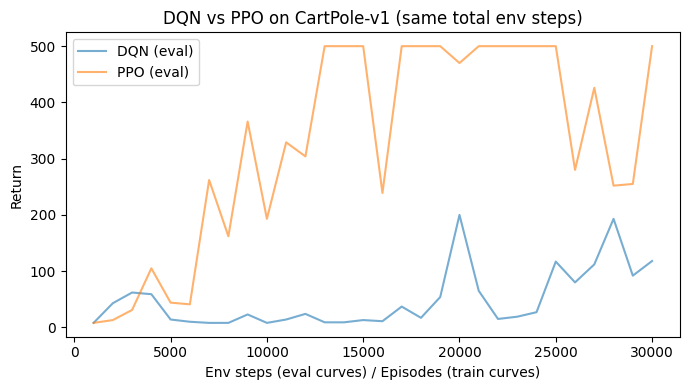

In [25]:
# ======================================================
# 4) Plot (same x-axis = env steps)
# ======================================================
plt.figure(figsize=(7,4))
# eval curves
plt.plot(dqn_res["eval_steps"], dqn_res["eval_scores"], label="DQN (eval)", alpha=0.6)
plt.plot(ppo_res["eval_steps"], ppo_res["eval_scores"], label="PPO (eval)", alpha=0.6)
plt.title(f"DQN vs PPO on {ENV_NAME} (same total env steps)")
plt.xlabel("Env steps (eval curves) / Episodes (train curves)")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()